In [1]:
import numpy as np
import os

from keras.datasets.cifar import load_batch
from keras.utils.data_utils import get_file
from keras import backend as K

def load_data():
    """Loads CIFAR10 dataset.

    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = 'cifar-10-batches-py'
    #origin = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    #path = get_file(dirname, origin=origin, untar=True)
    path = 'datasets/pankrzysiu-cifar10-python-momodel/' + dirname
    
    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000: i * 10000, :, :, :],
         y_train[(i - 1) * 10000: i * 10000]) = load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    return (x_train, y_train), (x_test, y_test)

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = load_data()


In [3]:
import matplotlib.pyplot as plt
plt.imshow(x_train[6])
label_dict={0:"airplane", 1:"automobile", 2:"bird", 3:"cat",4:"deer",
            5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}
print (label_dict[y_train[6][0]])

bird


In [4]:
x_train[0][0][0]

array([59, 62, 63], dtype=uint8)

In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


In [6]:
x_train[0][0][0]

array([0.23137255, 0.24313726, 0.24705882], dtype=float32)

In [7]:
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3,3),
                                 input_shape=(32,32,3),
                                 activation='relu',
                                 padding='same'
                                ))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=64,
                                 kernel_size=(3,3),
                                 input_shape=(32,32,3),
                                 activation='relu',
                                 padding='same'
                                ))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='softmax'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxP

In [8]:
epochs = 5
batch = 100


In [9]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [10]:
model_filename = 'results/cifarCNN.h5'
try:
    model.load_weights(model_filename)
    print("load model pass")
except:
    print("load model fail")

load model pass


In [11]:
logdir = './results/tb_results'
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=logdir),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_filename,
                                       save_weights_only=True,
                                       save_best_only=True,
                                      verbose=1
                                      ),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
]

In [12]:
history = model.fit(x_train, y_train,
                   validation_split=0.2,
                   epochs=epochs,
                   batch_size=batch,
                    callbacks=callbacks,
                   verbose=1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
39900/40000 [============================>.] - ETA: 0s - loss: 0.3836 - acc: 0.87913
Epoch 00001: val_loss improved from inf to 0.96216, saving model to results/cifarCNN.h5
40000/40000 [==============================] - 193s 5ms/sample - loss: 0.3842 - acc: 0.8788 - val_loss: 0.9622 - val_acc: 0.7082
Epoch 2/5
39900/40000 [============================>.] - ETA: 0s - loss: 0.3782 - acc: 0.88032
Epoch 00002: val_loss improved from 0.96216 to 0.94108, saving model to results/cifarCNN.h5
40000/40000 [==============================] - 203s 5ms/sample - loss: 0.3782 - acc: 0.8803 - val_loss: 0.9411 - val_acc: 0.7162
Epoch 3/5
39900/40000 [============================>.] - ETA: 0s - loss: 0.3893 - acc: 0.87739
Epoch 00003: val_loss did not improve from 0.94108
40000/40000 [==============================] - 208s 5ms/sample - loss: 0.3892 - acc: 0.8774 - val_loss: 0.9846 - val_acc: 0.7079
Epoch 4/5
39900/40000 [========================

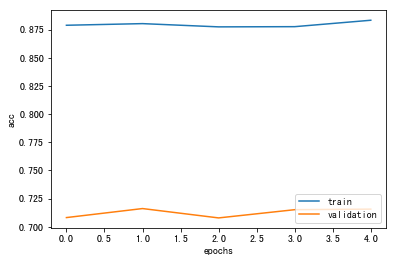

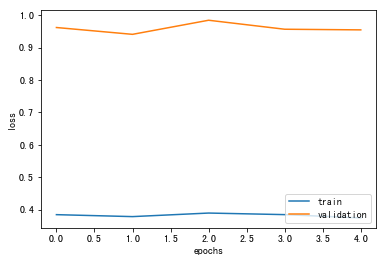

In [13]:
import matplotlib.pyplot as plt

def visual_train_history(history, train_metric, validation_metric):
    plt.plot(history.history[train_metric])
    plt.plot(history.history[validation_metric])
    plt.ylabel(train_metric)
    plt.xlabel('epochs')
    plt.legend(['train','validation'], loc='lower right')
    plt.show()
visual_train_history(history, 'acc', 'val_acc')
visual_train_history(history, 'loss', 'val_loss')

In [14]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 12s 1ms/sample - loss: 0.9756 - acc: 0.7104


[0.9756170088768006, 0.7104]

In [15]:
pred = model.predict_classes(x_test)
pred

array([3, 8, 0, ..., 5, 4, 7])

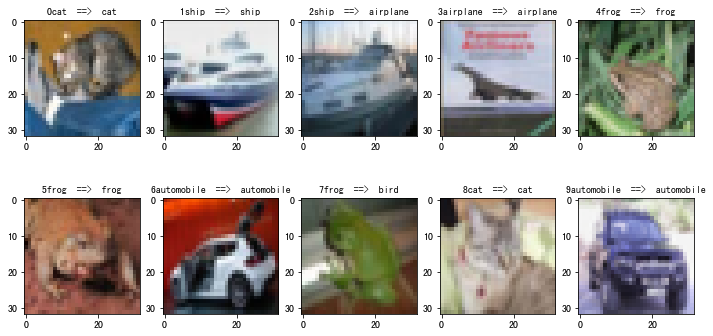

In [16]:
def plot_prediction(images, labels, preds, index, nums=5):
    fig = plt.gcf()
    fig.set_size_inches(12,6)
    if nums > 10:
        nums = 10
    for i in range(nums):
        ax = plt.subplot(2,5,i+1)
        ax.imshow(images[index])
        title = str(i) + label_dict[labels[index][0]]
        if (len(preds)>0):
            title += "  ==>  " + label_dict[preds[index]]
        ax.set_title(title, fontsize=10)
        index +=1
    plt.show()
plot_prediction(x_test, y_test, pred, 0 ,10)

In [48]:
model_filename = 'results/cifarCNN.h5'
model.save_weights(model_filename)